In [2]:
import numpy as np
import pandas as pd
from monke import functions as fct

data = pd.read_csv("magneton.csv").iloc[:2]
magneton = data["Magneton"].mean()
magneton_err = data["Magneton"].std() + data["Magneton Fehler"].mean()
print(fct.error_round(magneton*1e24, magneton_err*1e24,))

('9.2', '1.2')


# Auflösungsvermögen + Finesse

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from callibration import do_calibration
from scipy import odr, optimize
from typing import Callable
from monke import constants as ct
from monke import functions as fct

r = 0.85
wavelength = 644e-9
d = 4e-3
n = 1.457
mu = 9.274e-24

finesse = np.pi * np.sqrt(r) / (1 - r)
a = 2*n*d/wavelength * finesse

print(f"finesse = {finesse}, A = {a}")

data: pd.DataFrame = pd.DataFrame(np.loadtxt("../Data/Zeeman/kalibrierung_3.txt", skiprows=1),
                                             columns=["I / A", "B / mT"]).query("`I / A` < 9.5")
_, _, bfield, _ = do_calibration(data, sy=1) # in mT

i1 = (3.6, .1)
i2 = (1.3, .2)
a1 = ct.h*ct.c/(wavelength*mu*bfield(i1[0]) / 1000)
a1_err = a1 * i1[1] / i1[0]
print(f"auflösungsvermögen transversal: {fct.error_round(a1, a1_err)}")

a2 = ct.h*ct.c/(wavelength*mu*bfield(i2[0]) / 1000)
a2_err = a2 * i2[1] / i2[0]
a2 /= 2
a2_err /= 2

print(f"auflösungsvermögen transversal: {fct.error_round(a2, a2_err, "scientific")}")

finesse1 = a1*wavelength / (2*n*d), a1_err*wavelength / (2*n*d)
finesse2 = a2*wavelength / (2*n*d), a2_err*wavelength / (2*n*d)
print(f"finessee trans: {fct.error_round(*finesse1)}")
print(f"finessee longitudinal: {fct.error_round(*finesse2)}")





finesse = 19.309368757650553, A = 349487.58111673116


/home/gabriel/anaconda3/envs/p4_312/lib/python3.12/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


auflösungsvermögen transversal: ('137000', '4000')
auflösungsvermögen transversal: ('1.90000(30000)e5', 5)
finessee trans: ('7.5', '0.3')
finessee longitudinal: ('10.4', '1.7')


## Dopplerverbreiterung

Delta lambda = 1.3758048162472396 pm
delta_lambda gemessen: 3.2731768916779655 pm 0.07108940201090422 pm
a: 196750.74745803274, a_err: 4273.185790096337


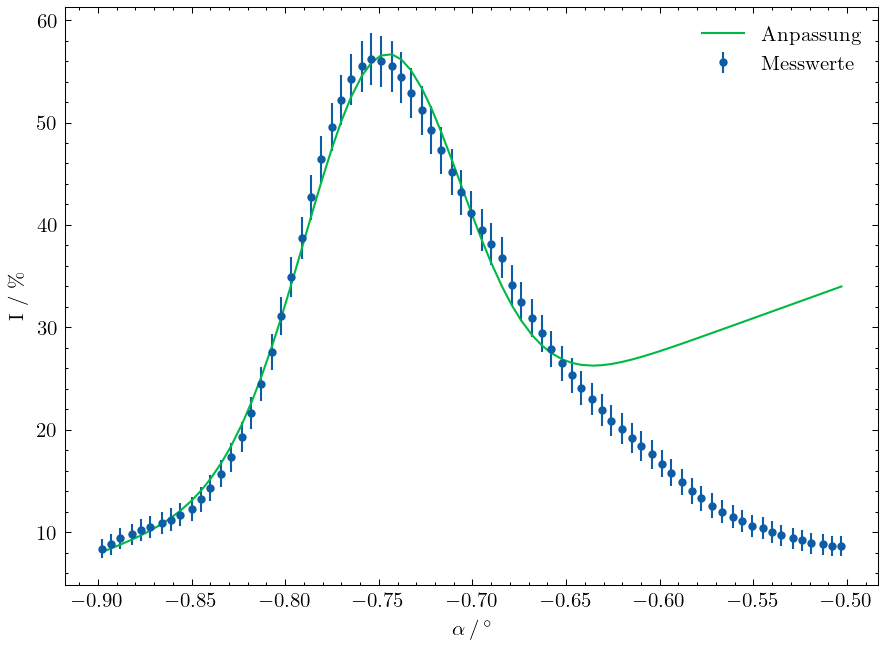

In [18]:
t = 1000
m = 112.4 * ct.u
delta_l = wavelength / ct.c *np.sqrt(t*8*ct.kb*np.log(2) / m)
print(f"Delta lambda = {delta_l*1e12} pm")

data = pd.DataFrame(np.loadtxt("../Data/Zeeman/messung1_woB.txt", skiprows=1), columns=["deg", "I"]).query("-.9 <= deg <= -.5")
data["error"] = np.sqrt(data.I) / 3


def fit_func(b, x):
    return b[2] / (np.sqrt(2*np.pi)*b[1]) * np.exp(-(x - b[0])**2 / (2*b[1]**2))  + b[3] + b[4]*x

fit_data = data.query("-.9 <= deg <=-.64")

popt, pcov = optimize.curve_fit(lambda x, a, b, c, d, e: fit_func([a, b, c, d, e], x), fit_data.deg, fit_data.I, sigma=fit_data.error)
pcov = pd.DataFrame(pcov, columns=["x0", "sigma", "A", "n", "m"], index=["x0", "sigma", "A", "n", "m"])
popt = pd.Series(popt, index=["x0", "sigma", "A", "n", "m"])

plt.figure(1)
plt.errorbar(data.deg, data.I, yerr=data.error, linestyle="", marker="o", ms=3, label="Messwerte")
fit: Callable[[float], float] = lambda x: fit_func(popt.to_numpy(), x)
plt.plot(data.deg, fit(data.deg), label="Anpassung")

delta_deg, delta_deg_err = popt.sigma*np.sqrt(2*np.log(2)), np.sqrt(pcov.sigma.sigma)*np.sqrt(2*np.log(2))
delta_lambda = - d / (18_104*n) *delta_deg*(delta_deg + 2*popt.x0) *(np.pi/180)**2  ## Umrechnung der Winkel in rad
delta_lambda_err = 2*d/(18_104*n) *np.sqrt(
    (delta_deg*np.sqrt(pcov.x0.x0))**2 +
    ((delta_deg + popt.x0)*delta_deg_err)**2
) * (np.pi/180)**2
print(f"delta_lambda gemessen: {delta_lambda*1e12} pm {delta_lambda_err*1e12} pm")

plt.xlabel(r"$\alpha\,/\,{}^\circ$")
plt.ylabel(r"I / \%")
plt.legend()
plt.savefig("../figs/doppler.pdf", dpi=200)
a, a_err = wavelength / delta_lambda, wavelength * delta_lambda_err / delta_lambda**2
print(f"a: {a}, a_err: {a_err}")

